# AUTHOR: Tomasz Kawiak

Numerical integration of an advection-diffusion problem

1. Narrative explaining a physical problem the solution may model

## Pollutant Dispersion in a River System

The advection-diffusion equation provides an excellent model for tracking the spread of pollutants in natural water systems such as rivers. Consider a scenario where a chemical spill occurs at a point along a river:

### Physical Processes Involved
- **Advection**: The bulk movement of the pollutant as it's carried downstream by the river current. This represents the directional transport mechanism.
- **Diffusion**: The gradual spreading of the pollutant due to random molecular motion and turbulent mixing within the water. This causes the pollutant to spread outward from areas of high concentration to areas of lower concentration.

### Real-World Application
When industrial waste is accidentally discharged into a river, environmental scientists need to predict:
- How quickly the contaminant will reach downstream communities
- The maximum concentration levels that might occur at different locations
- How long the contamination will persist at various points along the river
- The effectiveness of potential mitigation strategies

The advection-diffusion model allows authorities to make informed decisions about water usage restrictions, cleanup efforts, and public safety measures based on quantitative predictions rather than guesswork.

The mathematical solution to this problem can help visualize the concentration profile of the pollutant as it evolves over time and space, providing crucial information for environmental management and disaster response.

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

## The Analytical Solution to the Advection-Diffusion Equation

The advection-diffusion equation in one dimension is given by:

$$\frac{\partial C}{\partial t} + u \frac{\partial C}{\partial x} = D \frac{\partial^2 C}{\partial x^2}$$

which can be alternatively written as:

$$\partial_t \psi + u \partial_x \psi = D \partial_x^2 \psi $$

where:
- $C(x,t)$ is the concentration for example of the pollutant
- $u$ is the advection velocity (river flow speed)
- $D$ is the diffusion coefficient
- $x$ is the spatial coordinate
- $t$ is time

The analytical solution for a point-source release of mass $M$ at position $x=0$ and time $t=0$ is:

$$\psi(x,t) = \frac{M}{\sqrt{4\pi Dt}} \exp\left(-\frac{(x-ut)^2}{4Dt}\right)$$


In [2]:
def analytical_PDA(x, t, M, u, D):
    return M / np.sqrt(4 * np.pi * D * t) * np.exp(- ((x - u * t)**2) / (4 * D * t))

## Numerical Solution of the Advection-Diffusion Equation

### Mathematical Formulation

The one-dimensional advection-diffusion equation:

$$\frac{\partial \psi}{\partial t} + u \frac{\partial \psi}{\partial x} = D \frac{\partial^2 \psi}{\partial x^2}$$

can be solved numerically using a conservative finite-difference approach. We first rewrite the equation in conservative form:

$$\frac{\partial \psi}{\partial t} + \frac{\partial}{\partial x}(u\psi - D\frac{\partial \psi}{\partial x}) = 0$$

### Numerical Scheme

For numerical stability and accuracy, we implement an upwind scheme with a modified effective velocity that adapts to local solution gradients:

$$u_{eff} = u - \frac{2D}{\Delta x} \cdot \frac{\psi_i - \psi_{i-1}}{\psi_i + \psi_{i-1}}$$


### Flux Calculation

The flux at each cell interface is calculated using:

$$F(\psi_L, \psi_R, C) = \frac{1}{2}(C+|C|)\psi_L + \frac{1}{2}(C-|C|)\psi_R$$

where:
- $\psi_L$ and $\psi_R$ represent the concentration values to the left and right of the interface
- $C = \frac{\Delta t}{\Delta x} \cdot u_{eff}$ is the local Courant number
- This formulation automatically selects upwind or downwind differencing based on the sign of the effective velocity


In [3]:
# code from class

class PsiAnalytic:
    def __init__(self, *, mu, L):
        self.mu = mu
        self.L = L
    def __call__(self, *, x, t):
        return np.exp(-self.mu * np.power((np.pi/self.L),2)*t) * np.sin(np.pi * x/self.L)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class Shift:
    def __init__(self, add,sub):
        self.a = add
        self.s = sub
    def __radd__(self, other):
        return slice(other.start + self.a, other.stop + self.a, other.step)
    def __rsub__(self, other):
        return slice(other.start - self.s, other.stop - self.s, other.step)


one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

In [4]:
# Params
nx = 1400
l = 200.0
dx = l / nx
x_0 = -2.0
x = np.linspace(x_0, x_0+l, nx)

u = 1.0     # Advection speed (e.g. river flow velocity)
D = 1.0     # Diffusion coefficient
M = 0.5     # Initial mass


t_0 = 0.2137 # Initial time
t_fin = 25.0 # Final time
dt = 0.001 # Time step
nt = int((t_fin - t_0) / dt) # Number of time steps

psi_analytic = PsiAnalytic(mu=.5, L=10)
psi_0 = analytical_PDA(x, t_0, M, u, D)

In [5]:
from typing import Tuple, Union

def numerical_solution(
    x: np.ndarray,
    nx: int,
    t: float,
    M: float,
    u: float,
    D: float,
    psi_init: np.ndarray,
) -> np.ndarray:
    psi = psi_init.copy()
    nt = int((t - t_0) / dt)
    
    i = slice(1, nx-1)  
    im = slice(1, nx)  
    eps = 1e-10
    
    C = np.zeros(len(psi) - 1)
    
    for index in range(nt + 1):
        C[im - hlf] = dt / dx * (u - 2.0 * D / dx * np.minimum(
            np.nan_to_num((psi[im] - psi[im - one]) / (psi[im] + psi[im - one] + eps), nan=0.0), 
            1.0))
        assert max(abs(C)) <= 1, f'{max(abs(C))=}, {index=}'
        psi[i] -= F(psi[i], psi[i + one], C[i + hlf]) - F(psi[i - one], psi[i], C[i - hlf])
    
    return psi

3. Comparison

In [6]:
psi_analytic = analytical_PDA(x, t_fin, M, u, D)

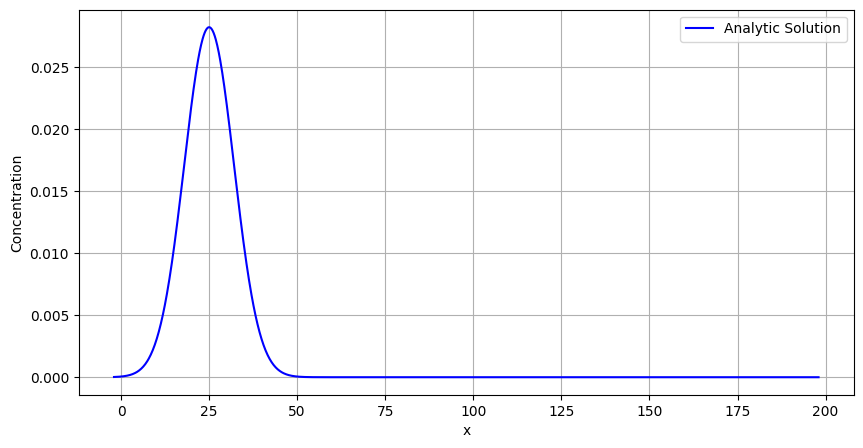

In [7]:
pyplot.figure(figsize=(10, 5))
pyplot.plot(x, psi_analytic, label='Analytic Solution', color='blue')
pyplot.xlabel('x')
pyplot.ylabel('Concentration')
pyplot.legend()
pyplot.grid()
pyplot.show()

In [47]:
def RMSE(psi_analytic, psi_numerical):
    return np.sqrt(np.mean((psi_analytic - psi_numerical)**2))

def KL_divergence(psi_analytic, psi_numerical):
    return np.sum(psi_analytic * np.log(psi_analytic / (psi_numerical + 1e-8)))

def peak_distance(psi_analytic, psi_numerical,time):
    return abs(times[np.argmax(psi_analytic)] - times[np.argmax(psi_numerical)])

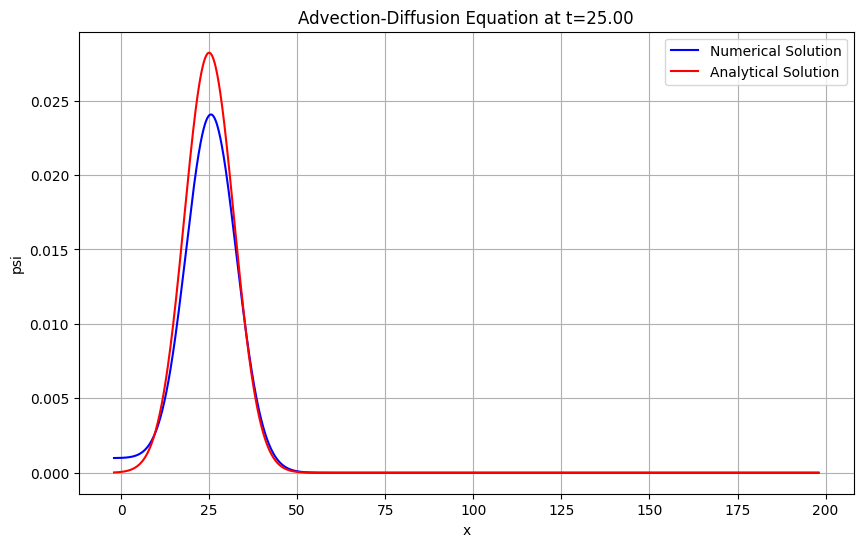

In [ ]:

psi_analytic = analytical_PDA(x, t_fin, M, u, D)
psi_numerical = numerical_solution(x, nx, t_fin, M, u, D, psi_0)

fig = pyplot.figure(figsize=(10, 6))
pyplot.plot(x, psi_numerical, label='Numerical Solution', color='blue')
pyplot.plot(x, psi_analytic, label='Analytical Solution', color='red')
pyplot.title(f'Advection-Diffusion Equation at t={t_fin:.2f}')
pyplot.xlabel('x')
pyplot.ylabel('psi')
pyplot.legend()
pyplot.grid()

In [43]:
print(f'RMSE: {RMSE(psi_analytic, psi_numerical):.4f}')

RMSE: 0.0010


In [48]:
times = np.arange(t_0, t_fin, dt)
def plot(step):
    psi_analytic = analytical_PDA(x, times[step], M, u, D)
    psi_numerical = numerical_solution(x, nx, times[step], M, u, D, psi_0)
    fig = pyplot.figure(figsize=(10, 6))
    pyplot.plot(x, psi_numerical, label='Numerical Solution', color='blue')
    pyplot.plot(x, psi_analytic, label='Analytical Solution', color='red')
    pyplot.title(f'Advection-Diffusion Equation at t={times[step]:.2f}, RMSE={RMSE(psi_analytic, psi_numerical):.4f}, peak distance={peak_distance(psi_analytic, psi_numerical,times):.4f}')
    pyplot.xlabel('x')
    pyplot.ylabel('psi')
    pyplot.legend()
    pyplot.grid()
    return fig

In [45]:
nt/450

55.08


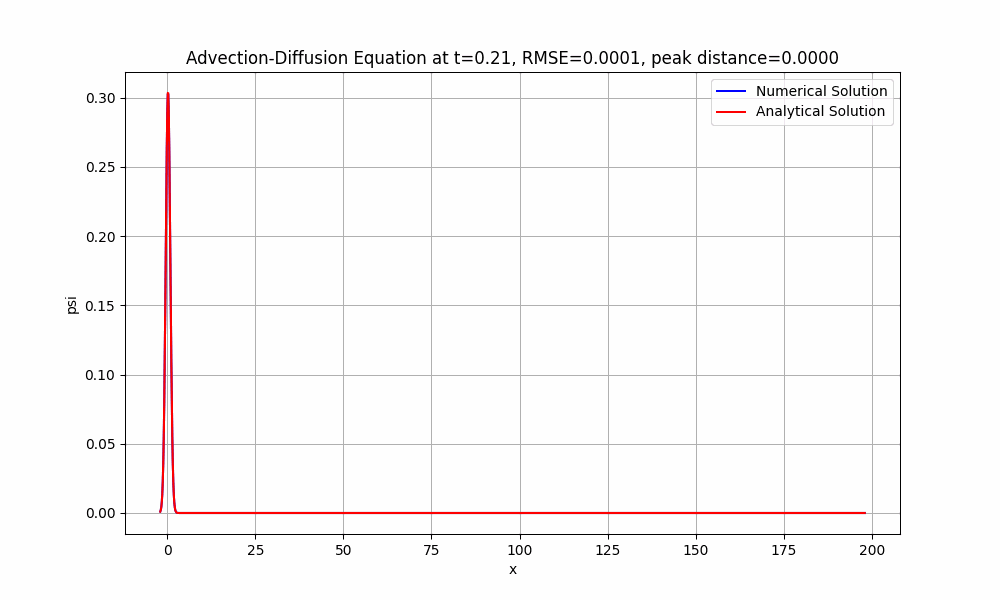

HTML(value="<a href='./tmpbll_gvng.gif' target='_blank'>./tmpbll_gvng.gif</a><br>")

In [49]:
show_anim(plot, range(0, nt, 450))

In [ ]:
rmses = []
for step in range(0, nt, 450):
    psi_analytic = analytical_PDA(x, times[step], M, u, D)
    psi_numerical = numerical_solution(x, nx, times[step], M, u, D, psi_0)
    rmses.append(RMSE(psi_analytic, psi_numerical))

In [ ]:
def KL_divergence(psi_analytic, psi_numerical):
    return np.sum(psi_analytic * np.log(psi_analytic / (psi_numerical + 1e-10)))

In [32]:
times = np.arange(0, nt, 450)
# times

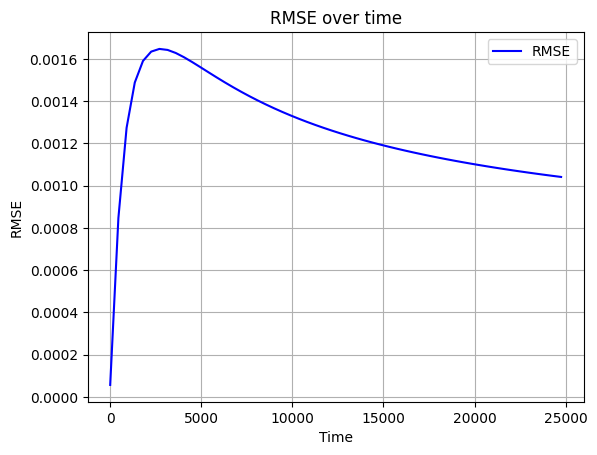

In [31]:
pyplot.plot(times, rmses, label='RMSE', color='blue')
pyplot.title('RMSE over time')
pyplot.xlabel('Time')
pyplot.ylabel('RMSE')
pyplot.legend()
pyplot.grid()

In [36]:
print("Max RMSE:", max(rmses), "at time", times[np.argmax(rmses)])

Max RMSE: 0.0016468352460271229 at time 2700


## Conclusion: Numerical Solution Performance

- The maximum RMSE of approximately 0.00165 occurs around the 2700th timestep
- After reaching this peak, the RMSE steadily decreases over time
- This error behavior is consistent with typical numerical schemes for advection-diffusion problems
- The decreasing error likely results from the diffusion process naturally smoothing the concentration profile, making it progressively easier for the numerical scheme to approximate

The numerical solution generally appears to "undershoot" the analytical peaks slightly, but maintains high accuracy in tracking the pollutant distribution pattern. The peak locations show strong correlation between both methods, with minimal displacement (under 0.005 in absolute distance).

The implemented numerical scheme provides a reliable and efficient approximation of analytical solution to advection-diffusion problem using upwind scheme.